In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# Cleaning Data

In [2]:
data = pd.read_csv("training_v2.csv")
df =  data.drop(data.iloc[:,:3], axis=1)
df = df.drop(["icu_id", "ethnicity", "height", "weight"], axis =1)

percent_missing = df.isnull().sum() * 100 / len(df)

# Drop column when too many NAs
drop = percent_missing.index[percent_missing.values>40].tolist()
df = df.drop(drop, axis = 1)

# Interpolate small amount of missing data based on class
fill = percent_missing.index[(percent_missing.values<40)].tolist()
neg = df[df["hospital_death"]==0]
pos = df[df["hospital_death"]==1]
for col in fill:
    if df[col].dtype == float: 
        pos[col]= pos[col].fillna(pos[col].mean())
        neg[col]= neg[col].fillna(neg[col].mean())
    else:
        pos[col]= pos[col].fillna(pos[col].mode(dropna= True))
        neg[col]= neg[col].fillna(neg[col].mode(dropna= True))
df = pd.concat([pos, neg])

# Transform categorical value into numeric
obj_col =list(df.select_dtypes(include=['O']).columns)
for col in obj_col:
    encode = OneHotEncoder().fit_transform(np.array(df[col]).reshape(-1,1)).toarray()
    encode=encode.astype(int)
    df[col] = [''.join(map(str, l)) for l in encode]
    df[col]=df[col].astype(float)

<ipython-input-2-8497e7bf41b5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos[col]= pos[col].fillna(pos[col].mode(dropna= True))
<ipython-input-2-8497e7bf41b5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col]= neg[col].fillna(neg[col].mode(dropna= True))
<ipython-input-2-8497e7bf41b5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [3]:
# Split dataset by class
maj = df[df.hospital_death==0]
minor = df[df.hospital_death==1]

X_train_maj, X_test_maj, y_train_maj, y_test_maj = train_test_split(
     maj.drop("hospital_death", axis =1),maj.hospital_death, test_size=0.2
)
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(
   minor.drop("hospital_death", axis =1),  minor.hospital_death, test_size=0.2
)

X_test = pd.concat((X_test_maj,X_test_min))
y_test = pd.concat((y_test_maj, y_test_min))

In [4]:
# Randomly sample from minority class
diff = len(X_train_maj)-len(X_train_min)
upsample = resample(X_train_min, replace = True, n_samples = diff )

# Add noise to class label 1
noise = np.random.normal(0,0.1, [diff, len(df.columns)-1])
upsample+= noise

# Remerge datasets
upsample = pd.concat([X_train_min, upsample])
X_train = pd.concat([X_train_maj, upsample])
y_train = np.concatenate((np.zeros(len(y_train_maj)), np.ones(len(upsample))))

In [5]:
# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test =scaler.transform(X_test)

# PCA

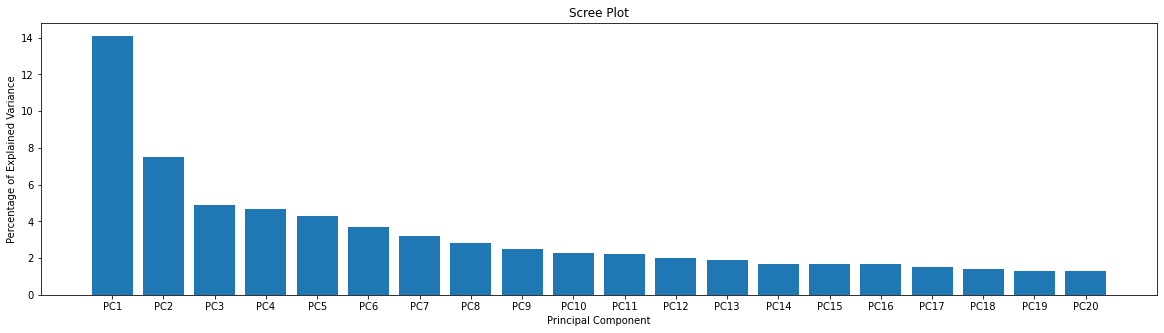

In [6]:
# Make a PCA model
pca = PCA(n_components = 20)
pca.fit(X_train)
train = pca.transform(X_train)
test = pca.transform(X_test)

# Draw a scree plot and PCA plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(20,5))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

# Random Forest

In [11]:
# search for an optimal value of max_depth for Random Forest
k_range = np.arange(10, 101, 10)
k_scores = []

for k in k_range:
    rf = RandomForestClassifier(class_weight = "balanced_subsample", max_depth = k)
    scores = cross_validate(rf, train, y_train, cv=5, scoring=['recall_macro'])
    # Append mean of scores for random forest to k_scores list
    k_scores.append(scores["test_recall_macro"].mean())

K = k_scores.index(max(k_scores)) # K with highest precision

forest = RandomForestClassifier(class_weight = "balanced_subsample", max_depth=k_range[K])
forest.fit(train, y_train)
y_pred = forest.predict(test)
print(f"Training recall score: {k_scores[K]}")
print(f"Testing recall score: {recall_score(y_test, y_pred)}")

Training recall score: 0.955599806334026
Testing recall score: 0.5262160454832596


In [12]:
print(f"Max depth of tree: {k_range[K]}")

Max depth of tree: 100
